In [50]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import urllib2
import re
from subprocess import PIPE, Popen
import os
import glob
import gzip
from itertools import islice
import ftplib
import math
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from scipy.stats.stats import pearsonr
import random
from sklearn import linear_model

<br><br>

# Introduction

There has been increasing interest into the use of epigenetic markers to assess for risk of disease etc. Particularly, methylation has been shown to correspond to cellular aging. However, existing methods of age prediction are based on very few tissue types, mainly teeth and bones, based on proteins content locked way in these tissue types. Thus in this project, we would like to do methylation marker based age prediction among a wide range of tissue types.

Moreover, cancer patients have shown increased tissue ageing as measured by methylation levels. So developing this predictor can help us identify potential risks to cancer.

Here is a great article that pursues a similar goal: http://www.genomebiology.com/2013/14/10/R115.

#Objective : 

We would look at developing age predictor based on DNA methylation epigenetic marker, and to establish a risk prognosis method in cancer patients based on regression and SVM classification. 


#Data:

For this study, methlyation datasets were obtained from Gene Expression Omnibus (GEO) database using GSE identifiers. 
File "geo-noncancer-datasets.txt" and "geo-cancer-datasets.txt" files provides an overview of the publicly available human DNAm data sets used in this study for cancer and non-cancer cases, respectively.  

Some sections of the code below will only run one GSE id for demo purpose. 

All the raw data and processed will be found here:
https://drive.google.com/folderview?id=0B5edDxPaIzYHQnlWR3lGMFYtOUk&usp=sharing

<br><br>


In [51]:
geo_noncancer_list = []
#read the non-cancer dataset list from tab delim file
noncancer_df=pd.read_csv('geo-noncancer-datasets.txt',sep='\t')
#extract the geo identifiers
geo_noncancer_list = list(set(noncancer_df.Availability)) 
print "Non-cancer datasets",len(geo_noncancer_list)

#read the non-cancer dataset list from tab delim file
cancer_df=pd.read_csv('geo-cancer-datasets.txt',sep='\t')
#extract the geo identifiers
geo_cancer_list = (cancer_df.Availability).values
print "Cancer datasets", len(geo_cancer_list)

Non-cancer datasets 48
Cancer datasets 7


DNA methylation relevant data was available in different files. 

For each GSE identifier there were Series matrix files  - containing expriment metadata like tissue source, chronogical age and experiment id's. 
Signal files -  These contained methlyation signals for every biomarker  as methylated and non-methylated, from which beta values were calculated. In some cases beta values were already made available. 

Data format challenges - There were many challenges in terms dowloading required files as there were no standard naming conventions and in some cases internal format was also quite different. Also, in some cases methlyation signals were available throgh series files instead of signal files.

Some of the edge cases had to be manually converted into a standard format in order for code to work.  

In [52]:
#ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE40nnn/GSE40700/matrix/GSE40700_series_matrix.txt.gz
#below functions check whether a ftp works for gse id according to standard format and downloads them 
#Note: download commands, adding a break in for loop for demo puropose, so that it shows working for one gseid
def check_urllink(ftplink):
    #check if the ftp link exists and check for edge cases 
    try:
        urllib2.urlopen(ftplink)
        return ftplink
    except urllib2.HTTPError, e:
        print(e.code)
        return 1
    except urllib2.URLError, e:
        print(e.args)
        return 1
    
#iterate over the accessions to get series file for metadata
#(these contain methylation signals in some cases)
def fetch_series_data(geo_noncancer_list):
    outdir ='data/geo-series'
    gse_noncancer_edge=[]
    failed_fetch_list = []
    for i in geo_noncancer_list:
        key_num = i.split("GSE")[1]
        url_key= "GSE"+key_num[0:2]
        file_n = i + "_series_matrix.txt.gz"
        url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/"+url_key.replace(" ","")+ "nnn/" + i + "/matrix/" 
        ftplink= (url + file_n).replace(" ","")
        result = check_urllink(ftplink)
        ftp_cmd= "cd " + outdir + "; ftp " + ftplink + " ;cd -"
        if result == 1:
            print "link failure, cannot find series files", ftplink
            gse_noncancer_edge.append(i)
        else:
            print "link Success: Fetching ", ftplink
            #below part triggers ftp download cmd in shell using subprocess
            pfetch = Popen(ftp_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
            std_out, std_err = pfetch.communicate()
            exit_code = pfetch.returncode
            if exit_code:
                failed_fetch_list.append(i)
            #os.system(ftp_cmd)
        #adding break here, just so that it works for one accession
        break
    return gse_noncancer_edge, failed_fetch_list 


In [53]:
#download noncancer datasets
gse_noncancer_edge, failed_fetch_list = fetch_series_data(geo_noncancer_list)

link Success: Fetching  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28746/matrix/GSE28746_series_matrix.txt.gz


In [54]:
#download series files for cancer datasets
gse_cancer_edge, failed_fetch_list = fetch_series_data(geo_cancer_list )

link Success: Fetching  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31979/matrix/GSE31979_series_matrix.txt.gz


In [55]:
print "number of GEO non-cancer edge cases", len(gse_noncancer_edge)
print "number of failed fetches for normal GEO data links" , len(failed_fetch_list)

number of GEO non-cancer edge cases 0
number of failed fetches for normal GEO data links 0


Earlier we downloaded series files (~6gb compressed series files), now below functions will get signal files (when done these were ~5gb compressed), 
signal files contain methylation and non methylation signals, which have to be converted into beta values
More about betavalues in methylation can be found here: http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3012676/

In [56]:
def ftp_listfiles(ftplink):
    filelist = []
    urlpath = urllib2.urlopen(ftplink)
    string = urlpath.read().decode('utf-8').encode()
    for txt in string.split("\n"):
        f = txt.split(" ")[-1]
        if re.search("signal", f) or re.search("Signal", f):
            filelist.append(f)
        elif re.search("normalize",f) or re.search("Normalize",f) :
            filelist.append(f)
    return filelist

def fetch_signalfiles(geo_list):
    gse_edge=[]
    failed_fetch_list = []
    outdir = 'data/geo-signals'
    for i in geo_list:
        i = i.replace(" ",'')
        key_num = i.split("GSE")[1]
        url_key= "GSE"+key_num[0:2]
        url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/"+url_key+ "nnn/" + i + "/suppl/"
        files = ftp_listfiles(url)
        for file_n in files:
            ftplink= (url + file_n).replace(" ","").replace("\r",'')
            result=check_urllink(ftplink)
            ftp_cmd= "cd " + outdir + "; ftp " + ftplink + " ;cd -"
            if result == 1:
                print "link failure, cannot find signal file", ftplink
                gse_edge.append(i)
            else:
                print "Link Success: Fetching ", ftplink
                pfetch = Popen(ftp_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
                std_out, std_err = pfetch.communicate()
                exit_code = pfetch.returncode
                if exit_code:
                    failed_fetch_list.append(i)
                #os.system(ftp_cmd)
            #adding break for demo purpose
        break
    return gse_edge, failed_fetch_list  

def beta_val(df):
    #Max(M,0)/[Max(M,0)+Max(U,0)+100]. 
    #beta val = methylated signal /(unmethylated signal + methylated signal + 100)
    #Thus, β values range from 0 (completely un-methylated) to 1 (completely methylated) . 
    return (float(df[1])/float(df[1] + df[0]+100))

In [57]:
signal_resem, failed = fetch_signalfiles(geo_noncancer_list)
len (signal_resem), len(failed)

Link Success: Fetching  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28746/suppl/GSE28746_non-normalized.txt.gz


(0, 0)

In [58]:
signal_resem, failed = fetch_signalfiles(geo_cancer_list)
len (signal_resem), len(failed)

Link Success: Fetching  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31979/suppl/GSE31979_matrix_signal_intensities.txt.gz


(0, 0)

Since the signal files were really big, I had to chunk them and read it sequentially processed them and append. Below functions work on chunk dataframes and return beta values. There is lot of scope for optimization by using spark parallel processing.  But decided to try optimizations later and make sure the method works first. 

In [59]:
def open_signalfile(file1):
    #accepts file and returns file chunk iterator
    signaldf_iter = None
    signaldf_iter=pd.read_csv(file1,sep="\t",comment="#",index_col=0,iterator=True, chunksize=10000)
    return signaldf_iter

def process_chunkdf(chunk):
    #for each chunk df calculates the beta values 
    betadf = pd.DataFrame()
    #print chunk.shape
    filter = []
    #dropping rows if any of them have NaN
    chunk.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    list_cols = chunk.columns
    #adding edge cases
    #this takes care of remvoing unwanted columns to reduce memory usage
    filter = ~(list_cols.str.contains("pval|background|probeid|symbol",case=False, regex=True))
    filter_cols = list_cols[filter]
    chunk=chunk[filter_cols]
    #print chunk.shape 
    #further check if the dataframe has beta values already.
    filter = filter_cols.str.contains("beta",case=False, regex=True)
    #if the file contain beta values already calculated, then fetch only those columns
    if np.sum(filter) > 0:
        filter_cols = filter_cols[filter]
        betadf=chunk[filter_cols]
        #rename index for consistency 
        betadf.index.names = ['cpg_id'] 
    else:
        #if file contains methlyated and unmethlyated then calculate beta values.
        chunk.index.names = ['cpg_id'] 
        for i in range(len(chunk.columns))[::2]:
            col_1 = chunk.columns[i]
            col_2 = chunk.columns[i+1]
            #print col_1 ,col_2
            #create column with polished name
            col_new = col_1.replace('Unmethylated Signal','').replace('Signal_A','')
            betadf[col_new] = chunk[[col_1,col_2]].apply(beta_val,axis=1)
    return betadf

def create_betasig_df(iterator):
    #takes file chunk iterater and returns betavalues df for full file
    finaldf = pd.DataFrame()
    i = 0
    for chunk in iterator:
        i= i +1
        #print chunk.shape
        betadf = process_chunkdf(chunk)
        finaldf = pd.concat([finaldf, betadf])
    return finaldf

In [60]:
def get_signal_methyldf(filearr):
    #iterates over signal files , get chunk iterators , beta values and writes them out to file
    outputpath = 'data/geo-betasignals/'
    trouble_samples = []
    for file1 in filearr:
        print file1
        tmpdf=pd.DataFrame()
        signaldf_iter = ''
        try:
            signaldf_iter = open_signalfile(file1)
            tmpdf = create_betasig_df(signaldf_iter)
        except Exception as e:
            trouble_samples.append(file1)
            continue
        #create output file name for betavalues
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        tmpdf.to_csv(outputpath+filename+'.csv',sep=',')
    return trouble_samples

Calling the beta value calculation functionality on each files and capture edge cases as trouble_samples. 

In [61]:
%%time
#demo block
filearr= glob.glob('data/geo-signals/'+'*.txt.gz')
trouble_samples = get_signal_methyldf(filearr)
print len(trouble_samples)

data/geo-signals/GSE28746_non-normalized.txt.gz
data/geo-signals/GSE31979_matrix_signal_intensities.txt.gz
0
CPU times: user 6min, sys: 7.23 s, total: 6min 7s
Wall time: 6min 46s


In [62]:
#full run, commenting out to avoid recalculation
filearr= glob.glob('data/geo-signals/'+'*.txt.gz')
#trouble_samples = get_signal_methyldf(filearr)
edge_case = ['GSE20236','GSE26033','GSE30090','GSE30780','GSE32146','GSE34257','GSE34639','GSE36064','GSE43269']
len(edge_case)

9

Had to manually curate the edge case signal files as the column structure was random.
There was no consistency or pattern among these to customize the code, moved them under "geo-nonuniform-signalfiles" dir and processed files to have - cpgid, non-methylation column, methylation column, pval(optional). 
And, repeated the beta val calculations

In [63]:
trouble_samples=glob.glob('data/geo-nonuniform-signalfiles/*.txt.gz')
#commenting out to avoid recalcualtion
#trouble_samples = get_signal_methyldf(trouble_samples)

some of the accessions did not have signal files, instead series files contained the beta values. 
We will deal with them later. Below function takes care of just reading series file into df.

In [64]:
def create_series_methyldf(file1):
    #read series file, skip comment line and return the df as methylation df
    maindf=pd.read_csv(file1,comment="!",sep="\t",index_col=0,skip_blank_lines=True)
    return maindf

In [65]:
gse_without_signals=['GSE17448','GSE20067','GSE30758','GSE32393','GSE41169','GSE42510','GSE40700','GSE32149','GSE19711','GSE20712','GSE25062']
for i in gse_without_signals:
    arr = glob.glob( 'data/geo-series/'+ i+ "*.txt.gz")
    for file1 in arr:
        tmpdf = create_series_methyldf(file1)
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        tmpdf.to_csv(outputpath+filename+'.csv',sep=',')

Below section takes care of downloading metadata from series files for every sample
Metadata includes : chronological age, gender , tissue source, sample GEO id, sample id and if cancer data

In [66]:
def create_metadata(file1,cancer=0):
    #approx number of lines to fetch tissue information
    N = 2000
    f = gzip.open(file1, 'rb')
    #Reading first 2000 lines, header lines are inconsistent but cannot contain such large number. 
    headerlines = islice(f, N)
    metadict = {'sample_geo_id':[],'age':[],'gender':[],'sample_id':[],'cancer':[]}
    for i in headerlines:
        line = i.strip("\n")
        if re.search('!Sample_geo_accession',line,re.IGNORECASE):
            metadict["sample_geo_id"] = line.replace('"','').split("\t")[1:]
            ref_len = len( metadict["sample_geo_id"] )
            #intialize metadata array lengths according to geo ref lengths
            #metadict["sample_id"] = metadict["sample_geo_id"]
            metadict["tissue_src"] = [np.nan]*ref_len
            metadict["age"] = [np.nan]*ref_len
            metadict["gender"] = [np.nan]*ref_len
            metadict["cancer"] = [cancer]*ref_len
        if re.search('!Sample_source_name_ch1',line,re.IGNORECASE):
            metadict["tissue_src"] = line.replace('"','').split("\t")[1:]
        if re.search('!Sample_title',line,re.IGNORECASE) :
            metadict["sample_id"] = line.replace('"','').split("\t")[1:]
        if re.search('!Sample_characteristics_ch1',line, re.IGNORECASE):
            #iterate over each line characteristics line to fetch age, gender info
            temp_arr = line.split("\t")[1:]
            for l in range(0,len(temp_arr)):
                ele = temp_arr[l]
                if re.search('ageatdiagnosis',ele, re.IGNORECASE) or re.search('"age',ele, re.IGNORECASE):
                    #check for months , default is years
                    ele = ele.replace('"','')
                    years = re.sub("[^0-9]", "", ele)
                    if re.search('month',ele,re.IGNORECASE):
                        years = float(years)/12.0
                    metadict["age"][l] = years
                if re.search('sex', ele, re.IGNORECASE) or re.search('gender', ele, re.IGNORECASE):
                    metadict["gender"][l] = ele.replace('gender','').replace('sex','').replace(':','').replace(' ','').replace('"','')
    metadatadf = pd.DataFrame(metadict)
    return metadatadf

In [67]:
%%time
datasets = glob.glob("data/geo-series/*txt.gz")
outputpath = 'data/geo-metadata/'
for file1 in datasets:
    #create output file name
    path,filename = os.path.split(file1)
    filename, ext = os.path.splitext(filename)
    filename, ext = os.path.splitext(filename)
    #check if the dataset is from cancer samples
    if (filename.split("_")[0]).replace("\t",'') in geo_cancer_list:
        flag= 1
    else:
        flag = 0
    metadf = create_metadata(file1,cancer=flag)
    metadf.to_csv(outputpath+filename+'_meta.csv',sep=',',index=False)

CPU times: user 660 ms, sys: 10.3 ms, total: 671 ms
Wall time: 685 ms


Normalization :

Since datasets were obtained from different platforms, it was curical for us to normalize the data for signals to be comparable. The Illumina 450K platforms uses two different chemical assays. We used R method from Teschendorff et al 2013 based on a intra-array normalization strategy for the 450K platform, called BMIQ (Beta MIxture Quantile dilation), which adjusts beta-values of type II probes into a statistical distribution characteristic of type I probes.  

Reference for normalization : Teschendorff AE, Marabita F, Lechner M, Bartlett T, Tegner J, Gomez-Cabrero D, Beck S: A beta-mixture quantile normalization method for correcting probe design bias in Illumina Infinium 450 k DNA methylation data. Bioinformatics 2013, 29:189-196.
http://www.ncbi.nlm.nih.gov/pubmed/23175756

In [68]:
normfailed=[]
def normalize_datasets(file1):
        outputpath = 'data/geo-normalized/'
        probeannotfile = 'probeAnnotation21kdatMethUsed.csv'
        #create output file name for betavalues
        path,filename = os.path.split(file1)
        filename, ext = os.path.splitext(filename)
        filename, ext = os.path.splitext(filename)
        outfile = outputpath + "/" + filename +"_norm.csv"
        norm_cmd = "Rscript  Normalization.R " + file1 + " " + probeannotfile + " " + outfile
        pnorm = Popen(norm_cmd,stdout=PIPE,stderr=PIPE,shell=True,close_fds=True)
        std_out, std_err = pnorm.communicate()
        exit_code = pnorm.returncode
        if exit_code:
            print "normalization error", file1
            normfailed.append(file1+ ":"+norm_cmd )
        return normfailed        

In [69]:
%%time
filearr= glob.glob('data/geo-betasignals/'+'*.csv')
for file1 in sorted(filearr):
    path,f = os.path.split(file1)
    failnorm_files = normalize_datasets(file1)
    #adding break to iterate over only one file for demo
    break

normalization error data/geo-betasignals/GSE28746_non-normalized.csv
CPU times: user 1.57 ms, sys: 6.69 ms, total: 8.25 ms
Wall time: 5.08 s


For our studies only 21k probes will retained and sample id will be replaced with geo accessions.
Also, age, tissue_src and other metadata will be added to normalized dataframe to final df

In [86]:
#extract cpgid for 21k probes
probdf=pd.read_csv('probeAnnotation21kdatMethUsed.csv')
#extract tissue information for all geo-accessions, cancer and non-cancer
standard_tissuedf = pd.read_csv("geo-accession-tissueinfo.txt", sep="\t")
#reading the file for tissue info for each geo accession
tissue_list = list(standard_tissuedf["Availability"].values)
#fetch normalized files 
normalized_files = glob.glob('data/geo-normalized/*_norm.csv')
metadir = 'data/geo-metadata/'
preprocess_outdir = 'data/geo-preprocessed/'
for file1 in normalized_files:
    """iterate over normalized files and based on filename accession
    fetch metadata and merge them. Since tissue_src line is too lengthy
    we will use shortened versions which we read from standard-tissuedf"""
    try:
        path,filename = os.path.split(file1)
        gse_id = filename.split("_")[0]
        metafile = glob.glob(metadir + '/' + gse_id + "*")[0] 
        metadf = pd.read_csv(metafile)
        #get standard tissue name and replace in metadf 
        #removing the tissue_src information with standard tissue notations. 
        #for example  : "uterine cervix" instead of "genomic dna from uterine cervix"
        if gse_id in tissue_list:
            idx = tissue_list.index(gse_id)
            tissue_name = standard_tissuedf["DNA origin"][idx]   
            metadf["tissue_src"] = [tissue_name] * metadf.shape[0]
        print tissue_name
        normdf = pd.read_csv(file1,index_col=0)
        normdf.reset_index(inplace=True)
        normdf.set_index("index",inplace=True)
        normdf.columns = list(probdf["Name"])
        normdf.reset_index(inplace=True)
        if re.search("GS",normdf["index"][0]):
            normdf.rename(columns={"index":"sample_geo_id"}, inplace=True)
        else:
            normdf.rename(columns={"index":"sample_id"}, inplace=True)
        resultdf = pd.concat([normdf, metadf], axis=1, join_axes=[normdf.index])
        resultdf = resultdf.T.groupby(level=0).first().T
        resultdf.to_csv(preprocess_outdir+filename.replace("_norm.csv","_final.csv"),sep=',', index=False)
    except Exception as e:
        print "verify data", file1
        print "exception ", e

Saliva
Breast


In [71]:
standard_tissuedf["DNA origin"].values

array(['MSC (bonemarrow)', 'Blood WB', 'Blood WB', 'Blood WB', 'Blood WB',
       'Buccal', 'Blood CD4+CD14', 'Dermal fibroblast', 'Buccal', 'Heart',
       'Chimp+Human Tissues', 'Prostate NL', 'Sperm', 'Blood PBMC',
       'Blood Cord', 'Saliva', 'HematopoieticStemAndNormalPrimaryTissue',
       'hESC                                      ', 'Gastric',
       'Stem cells+Somatic Cells', 'Uterine Cervix', 'Blood PBMC',
       'Stem cells+Somatic Cells', 'Colon', 'Blood PBMC', 'Breast NL',
       'Saliva', 'Saliva', 'Blood Cord', 'Blood CD4 Tcells',
       'Blood Cell Types', 'Blood PBMC', 'Muscle', 'Blood Cord',
       'Blood PBMC', 'Reprogrammed mesenchymal stromal cells ', 'Liver ',
       'Fat Adip', 'Muscle', 'Brain Cerebellar', 'Brain Occipital Cortex',
       'Brain CRBLM', 'Various Tissues', 'Blood WB', 'Blood WB', 'Ape WB',
       'BrainVariousCells', 'Heart', 'Buccal', 'Buccal',
       'Blood Cell Types', 'Cartilage Knee', 'Placenta', 'Sperm', 'Brain',
       'Breast', 'Colore

## Data exploration and modeling:



In [72]:
processArray = glob.glob('data/geo-preprocessed/'+'*.csv.gz')
len(processArray)

39

In [87]:
%%time
#Creating one large dataframe from all of the normalized data

for dfInd in range(0, len(processArray)):
    df = pd.read_csv(processArray[dfInd])
    if (dfInd == 0):
        preprocAll = df
    else:
        preprocAll = preprocAll.append(df)


CPU times: user 1min 48s, sys: 26.1 s, total: 2min 14s
Wall time: 2min 30s


In [88]:
print "Dimensions of full matrix: ", preprocAll.shape
preprocAll = preprocAll[~preprocAll['age'].apply(np.isnan)]
print "Dimensions after removing NaN age: ", preprocAll.shape
preprocAll.head(3)

Dimensions of full matrix:  (4234, 21374)
Dimensions after removing NaN age:  (2760, 21374)


age  cancer  cg00000292  cg00002426  cg00003994  cg00005847  cg00007981  cg00008493  cg00008713  cg00009407  cg00011459  cg00012199  cg00012386  cg00012792  cg00013618  cg00014085  cg00014837  cg00015770  cg00019495  cg00020533  cg00021527  cg00022866  cg00024396  cg00024812  cg00025991  cg00027083  cg00027674  cg00029826  cg00031162  cg00032227  cg00033516  cg00033773  cg00034039  cg00035347  cg00035623  cg00037763  cg00037940  cg00040861  cg00040873  cg00043004  cg00043080  cg00044245  \
0   50       0    0.249439    0.200710    0.051357    0.742340    0.027400    0.969301    0.026876    0.076392    0.913424    0.022401    0.021674    0.040939    0.587426    0.032701    0.856025    0.154357    0.195630    0.900833    0.017518    0.655288    0.079444    0.038857    0.497367    0.031832    0.063149    0.080270    0.250808    0.023048    0.023196    0.760483    0.115967    0.402469    0.137319    0.921279    0.834481    0.019326    0.192374    0.050972    0.883098    0.117687   
1   50       0    0.308393    0.156496    0.046323    0.774976    0.031397    0.972898    0.034388    0.059107    0.898251    0.016743    0.026882    0.035031    0.538918    0.033689    0.868578    0.096916    0.322353    0.843714    0.023248    0.616212    0.062367    0.035271    0.351826    0.041107    0.075486    0.080144    0.358332    0.020370    0.037010    0.884545    0.163881    0.340100    0.230774    0.903996    0.880255    0.025161    0.175720    0.091887    0.922546    0.101318   
2   21       0    0.264882    0.115070    0.040636    0.582202    0.030823    0.970228    0.034255    0.068475    0.866214    0.016213    0.045897    0.044912    0.616433    0.091644    0.864787    0.092358    0.087612    0.897860    0.026272    0.690331    0.061439    0.034884    0.488411    0.023026    0.076324    0.098320    0.255581    0.019823    0.028036    0.807688    0.138641    0.416316    0.112507    0.905818    0.862345    0.032410    0.192246    0.023264    0.881104    0.082550   

   cg00047050  cg00047469  cg00050312  cg00051979  cg00054706  cg00056767  cg00057593  cg00058938        ...         cg27600794  cg27601516  cg27603796  cg27606341  cg27607639  cg27609819  cg27610250  cg27610561  cg27611665  cg27611781  cg27613076  cg27614038  cg27619475  cg27622610  cg27623214  cg27625732  cg27626102  cg27626299  cg27626318  cg27626424  cg27626899  cg27627570  cg27628312  cg27631256  cg27631817  cg27633903  cg27634151  cg27635271  cg27637521  cg27638597  cg27638672  \
0    0.069086    0.047490    0.024613    0.089200    0.027082    0.051814    0.359395    0.372161        ...           0.807422    0.114480    0.087505    0.821243    0.028356    0.819309    0.012857    0.937965    0.013561    0.049636    0.055204    0.041294    0.054690    0.638939    0.839934    0.676104    0.115339    0.193929    0.034935    0.922266    0.099631    0.019241    0.014042    0.828147    0.338333    0.096003    0.053057    0.201522    0.017144    0.018325    0.027236   
1    0.046231    0.043950    0.020741    0.095850    0.028801    0.037264    0.687618    0.340435        ...           0.605272    0.100390    0.073166    0.784987    0.027648    0.790344    0.016722    0.929948    0.010669    0.061113    0.060875    0.041263    0.129184    0.678039    0.822494    0.712357    0.118902    0.124903    0.032283    0.885868    0.116979    0.018599    0.018080    0.903415    0.139440    0.128764    0.050339    0.273106    0.016024    0.016994    0.046208   
2    0.040390    0.035464    0.015939    0.083124    0.024062    0.035684    0.363320    0.369186        ...           0.721347    0.105548    0.078780    0.704914    0.019603    0.757573    0.036962    0.912017    0.009491    0.055991    0.048848    0.036295    0.031902    0.545673    0.813566    0.690370    0.119424    0.116485    0.038911    0.910296    0.108163    0.013844    0.011653    0.779531    0.223433    0.108624    0.047437    0.107551    0.018041    0.021593    0.045750   

   cg27638713  cg27641018  cg27643859  cg2764

In [89]:
#Using only non-cancer set for PCA and regression
preprocFull = preprocAll[preprocAll['cancer'] != 1]
#Using cancer set for prediction
cancer = preprocAll[preprocAll['cancer'] == 1]

In [90]:
preprocFull['cancer'] = preprocFull['cancer'].astype('int')
print "Number of cancer cases: ", sum(preprocFull['cancer'])

Number of cancer cases:  0


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
cancer['cancer'] = cancer['cancer'].astype('int')
print "Number of normal cases: ", sum(cancer['cancer']!=1)

Number of normal cases:  0


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [92]:
preprocFull.head()

age  cancer  cg00000292  cg00002426  cg00003994  cg00005847  cg00007981  cg00008493  cg00008713  cg00009407  cg00011459  cg00012199  cg00012386  cg00012792  cg00013618  cg00014085  cg00014837  cg00015770  cg00019495  cg00020533  cg00021527  cg00022866  cg00024396  cg00024812  cg00025991  cg00027083  cg00027674  cg00029826  cg00031162  cg00032227  cg00033516  cg00033773  cg00034039  cg00035347  cg00035623  cg00037763  cg00037940  cg00040861  cg00040873  cg00043004  cg00043080  cg00044245  \
0   50       0    0.249439    0.200710    0.051357    0.742340    0.027400    0.969301    0.026876    0.076392    0.913424    0.022401    0.021674    0.040939    0.587426    0.032701    0.856025    0.154357    0.195630    0.900833    0.017518    0.655288    0.079444    0.038857    0.497367    0.031832    0.063149    0.080270    0.250808    0.023048    0.023196    0.760483    0.115967    0.402469    0.137319    0.921279    0.834481    0.019326    0.192374    0.050972    0.883098    0.117687   
1   50       0    0.308393    0.156496    0.046323    0.774976    0.031397    0.972898    0.034388    0.059107    0.898251    0.016743    0.026882    0.035031    0.538918    0.033689    0.868578    0.096916    0.322353    0.843714    0.023248    0.616212    0.062367    0.035271    0.351826    0.041107    0.075486    0.080144    0.358332    0.020370    0.037010    0.884545    0.163881    0.340100    0.230774    0.903996    0.880255    0.025161    0.175720    0.091887    0.922546    0.101318   
2   21       0    0.264882    0.115070    0.040636    0.582202    0.030823    0.970228    0.034255    0.068475    0.866214    0.016213    0.045897    0.044912    0.616433    0.091644    0.864787    0.092358    0.087612    0.897860    0.026272    0.690331    0.061439    0.034884    0.488411    0.023026    0.076324    0.098320    0.255581    0.019823    0.028036    0.807688    0.138641    0.416316    0.112507    0.905818    0.862345    0.032410    0.192246    0.023264    0.881104    0.082550   
3   25       0    0.270769    0.104574    0.043619    0.730222    0.043277    0.978465    0.034968    0.054918    0.858166    0.013167    0.021137    0.068776    0.656508    0.047355    0.746991    0.132977    0.173293    0.893145    0.025026    0.684200    0.099495    0.035905    0.531468    0.029461    0.071989    0.111074    0.278317    0.025379    0.022866    0.786200    0.113023    0.380974    0.088755    0.892115    0.854511    0.022257    0.187057    0.061840    0.915802    0.088510   
4   24       0    0.216965    0.151096    0.065225    0.802321    0.041912    0.980798    0.023780    0.057312    0.919690    0.011575    0.045874    0.049890    0.659202    0.024493    0.835712    0.113051    0.121643    0.918345    0.027816    0.650203    0.076316    0.037042    0.418421    0.022834    0.102436    0.089969    0.352643    0.027845    0.063814    0.772561    0.132015    0.337292    0.099577    0.898606    0.868258    0.025893    0.153893    0.051451    0.927559    0.087017   

   cg00047050  cg00047469  cg00050312  cg00051979  cg00054706  cg00056767  cg00057593  cg00058938        ...         cg27600794  cg27601516  cg27603796  cg27606341  cg27607639  cg27609819  cg27610250  cg27610561  cg27611665  cg27611781  cg27613076  cg27614038  cg27619475  cg27622610  cg27623214  cg27625732  cg27626102  cg27626299  cg27626318  cg27626424  cg27626899  cg27627570  cg27628312  cg27631256  cg27631817  cg27633903  cg27634151  cg27635271  cg27637521  cg27638597  cg27638672  \
0    0.069086    0.047490    0.024613    0.089200    0.027082    0.051814    0.359395    0.372161        ...           0.807422    0.114480    0.087505    0.821243    0.028356    0.819309    0.012857    0.937965    0.013561    0.049636    0.055204    0.041294    0.054690    0.638939    0.839934    0.676104    0.115339    0.193929    0.034935    0.922266    0.099631    0.019241    0.014042    0.828147    0.338333    0.096003    0.053057    0.201522    0.017144    0.018325    0.027236   
1    0.046231    0.043950    0.0

In [93]:
cancer.head()

age  cancer  cg00000292  cg00002426  cg00003994  cg00005847  cg00007981  cg00008493  cg00008713  cg00009407  cg00011459  cg00012199  cg00012386  cg00012792  cg00013618  cg00014085  cg00014837  cg00015770  cg00019495  cg00020533  cg00021527  cg00022866  cg00024396  cg00024812  cg00025991  cg00027083  cg00027674  cg00029826  cg00031162  cg00032227  cg00033516  cg00033773  cg00034039  cg00035347  cg00035623  cg00037763  cg00037940  cg00040861  cg00040873  cg00043004  cg00043080  cg00044245  \
0    1       1    0.742377    0.489831    0.088110    0.530238    0.055664    0.972224    0.038776    0.021043    0.918520    0.021043    0.038776    0.021043    0.792886    0.021043    0.792886    0.307997    0.196877    0.850245    0.021043    0.611053    0.021043    0.038776    0.489831    0.398914    0.358506    0.134788    0.499932    0.021043    0.072061    0.884638    0.088110    0.429219    0.088110    0.898244    0.857171    0.021043    0.267590    0.103887    0.870950    0.134788   
1    1       1    0.845257    0.424936    0.124736    0.718023    0.062314    0.978960    0.030818    0.015145    0.893818    0.030818    0.030818    0.030818    0.815718    0.030818    0.853433    0.210006    0.297932    0.893818    0.030818    0.796179    0.062314    0.046569    0.649636    0.708253    0.659405    0.155469    0.678944    0.030818    0.062314    0.917623    0.093666    0.317471    0.093666    0.917623    0.885809    0.030818    0.268623    0.268623    0.893818    0.093666   
2    1       1    0.596649    0.203046    0.257713    0.607583    0.070087    0.985134    0.020305    0.020305    0.815318    0.020305    0.050225    0.050225    0.782518    0.020305    0.705984    0.552916    0.388914    0.826251    0.030305    0.837185    0.030305    0.030305    0.541982    0.080005    0.356114    0.246779    0.552916    0.050225    0.060161    0.847185    0.050225    0.345180    0.099824    0.920973    0.880757    0.020305    0.119627    0.080005    0.897105    0.040275   
3    1       1    0.885246    0.445778    0.192806    0.536848    0.084960    0.966961    0.021820    0.021820    0.902303    0.021820    0.034075    0.034075    0.698750    0.034075    0.902303    0.192806    0.182687    0.927334    0.021820    0.678512    0.034075    0.046602    0.597561    0.304114    0.263638    0.192806    0.678512    0.021820    0.046602    0.951507    0.059295    0.557086    0.084960    0.927334    0.885246    0.034075    0.162568    0.046602    0.885246    0.084960   
4    0       1    0.559516    0.193938    0.299763    0.530654    0.071281    0.969555    0.025796    0.011677    0.866346    0.025796    0.025796    0.040646    0.684582    0.040646    0.790407    0.549895    0.290143    0.809648    0.011677    0.790407    0.040646    0.055863    0.578757    0.501793    0.501793    0.184317    0.626859    0.025796    0.055863    0.694202    0.071281    0.290143    0.174697    0.944604    0.875214    0.025796    0.102399    0.242040    0.901591    0.055863   

   cg00047050  cg00047469  cg00050312  cg00051979  cg00054706  cg00056767  cg00057593  cg00058938     ...      cg27600794  cg27601516  cg27603796  cg27606341  cg27607639  cg27609819  cg27610250  cg27610561  cg27611665  cg27611781  cg27613076  cg27614038  cg27619475  cg27622610  cg27623214  cg27625732  cg27626102  cg27626299  cg27626318  cg27626424  cg27626899  cg27627570  cg27628312  cg27631256  cg27631817  cg27633903  cg27634151  cg27635271  cg27637521  cg27638597  cg27638672  cg27638713  \
0    0.072061    0.038776    0.021043    0.072061    0.021043    0.055664    0.570645    0.307997     ...        0.681766    0.196877    0.287793    0.489831    0.021043    0.752479    0.038776    0.742377    0.021043    0.103887    0.021043    0.021043    0.742377    0.378710    0.701970    0.641358    0.469627    0.631257    0.038776    0.931968    0.072061    0.021043    0.021043    0.419118    0.520136    0.119437    0.358506    0.752479    0.103887    0.021043    0.055664    0.103887   
1    0.170697    0.0

In [94]:
#Setting up the x and y matrices. metColumns contains the column names for the variables we want to include
#in our regression. Right now it only contains the CpG sites, because the gender is not available for all 
#datasets. You can add variables by appending the column name into metColumns
metColumns = preprocFull.columns[[re.match(r"cg", col) != None for col in preprocFull.columns]].values.tolist()


#appending cancer as one of the variables
#metColumns.append('cancer')
metDFx = preprocFull[metColumns]
cancerDFx=cancer[metColumns]

#Separating response variable
metDFy = pd.DataFrame(preprocFull['age'])
cancerDFy = pd.DataFrame(cancer['age'])

In [95]:
print metDFx.shape
print metDFy.shape

print cancerDFx.shape
print cancerDFy.shape

(2231, 21368)
(2231, 1)
(529, 21368)
(529, 1)


In [96]:
def replaceNan(column):
    columnFix = column.fillna(column.mean())
    return columnFix
metDFx = metDFx.apply(replaceNan)
cancerDFx = cancerDFx.apply(replaceNan)

Therea are 21374 features, we will just plot random 40 and look at the relation. 
After feature selection, we will again plot those.

In [97]:
def plot_kde(ax1,colname, df):
    sns.set_style("whitegrid")
    sns.kdeplot(df[df.cancer==1][colname], shade=True, color="g", alpha=0.6,ax=ax1, label="positive-"+colname)
    sns.kdeplot(df[df.cancer==0][colname], shade=True, color="b",alpha=0.5,ax=ax1, label="negative-"+colname)

As part of initial data exploration plotted random 40 cpg biomarker methylation signal features between cancer and non-cancer sets how they separate Some of them separate the two class well and some of them dont. This shows not all of them are informative for classification purpose.  There is potential for feature selection optimization. 

/Users/triptik/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/triptik/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


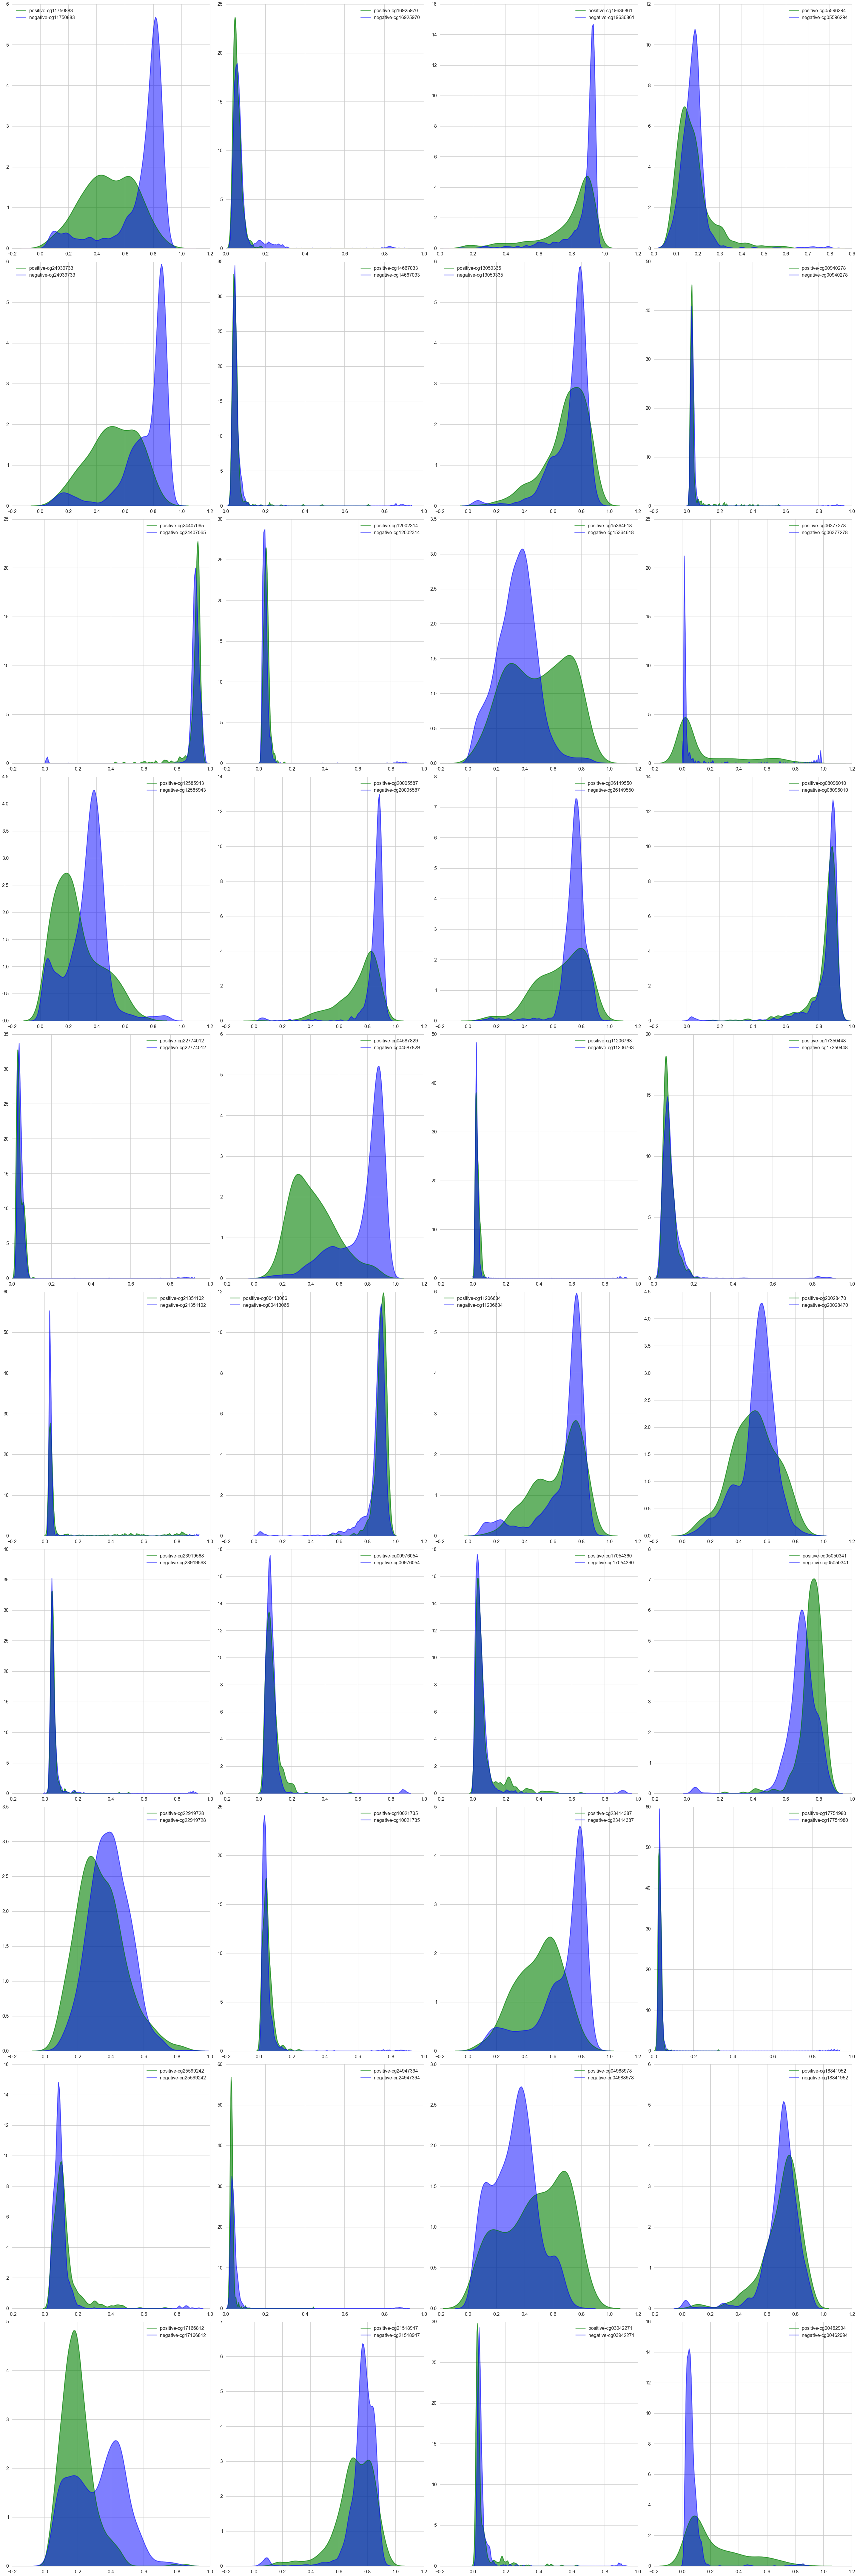

In [98]:
# Make a kernel-density estimate plot of each feature 
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(40, 120), 
                        tight_layout=True)
for ax1,colname in zip(axes.ravel(),random.sample(metColumns, 40)):
    plot_kde(ax1,colname,preprocAll)

In [99]:
# Select the training data from normal dataset
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(preprocFull.shape[0]), train_size=0.7)
mask=np.ones(preprocFull.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask.shape, mask.sum()

((2231,), 1561)

In [100]:
Xmatrix_train=metDFx[mask]
Xmatrix_test=metDFx[~mask]
Yresp_train=metDFy[mask]['age']
Yresp_test=metDFy[~mask]['age']
Xmatrix_cancer=cancerDFx
Yresp_cancer=cancerDFy['age']

In [101]:
print Xmatrix_train.shape
print Yresp_train.shape

(1561, 21368)
(1561,)


In [102]:
%%time
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Xmatrix_train)

CPU times: user 46.1 s, sys: 1.97 s, total: 48 s
Wall time: 26.7 s


In [103]:
sums = np.cumsum(pca.explained_variance_ratio_)*100
x = 0
x90=0
k = 0
k90=0
while (k<95):
    k = sums[x]
    x+=1
print "95% of variance explained in: ", x, " components"

while (k90<90):
    k90 = sums[x90]
    x90+=1
print "90% of variance explained in: ", x90, " components"

95% of variance explained in:  124  components
90% of variance explained in:  22  components


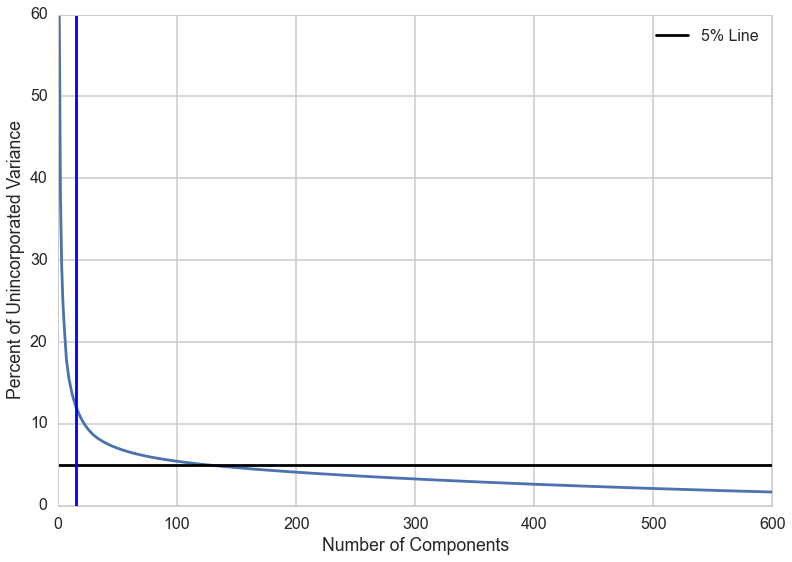

In [104]:
#Variance explained by the principal components
missingVariance = (1 - np.cumsum(pca.explained_variance_ratio_))*100
numComponents = np.arange(1, len(missingVariance)+1)
plt.plot(numComponents, missingVariance)
plt.axhline(5, color='k', label="5% Line")
plt.xlim(0,600)
plt.ylabel("Percent of Unincorporated Variance")
plt.xlabel("Number of Components")
plt.axvline(15)
plt.legend()

In [105]:
testComp = pca.components_[2]

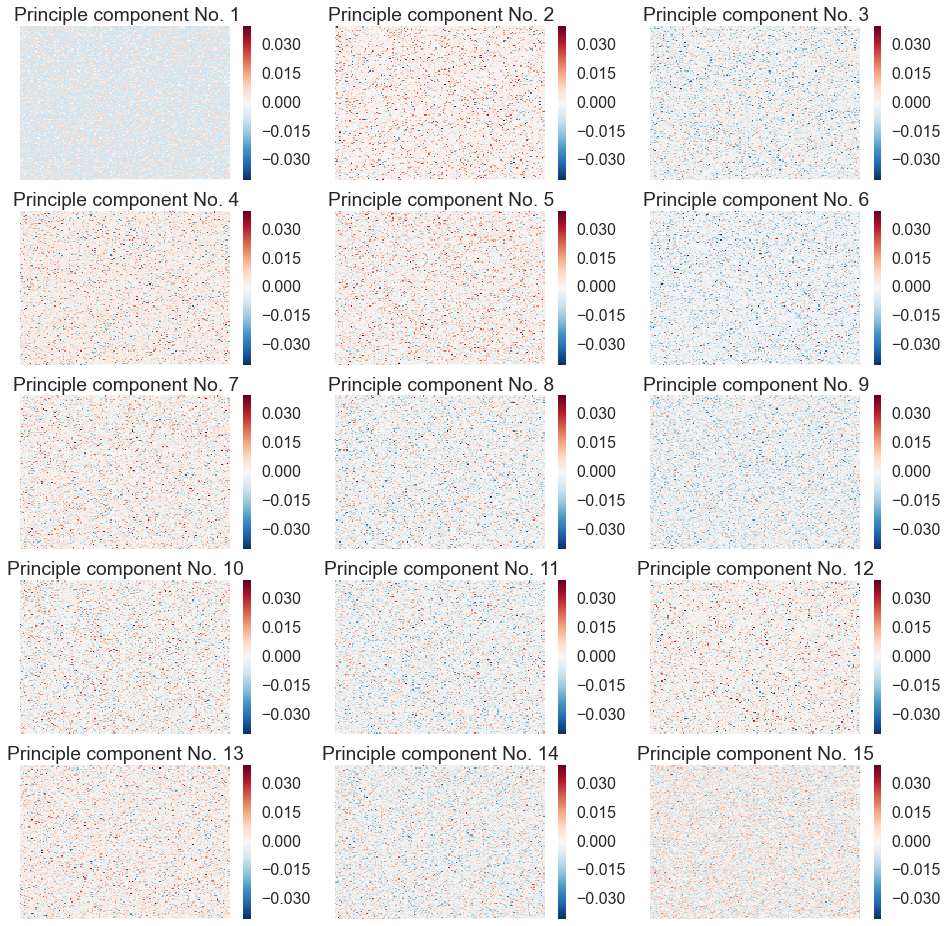

In [106]:
#I took the first 15 principle components that "explained" >90% of the variance, converted their arrays to
#a square matrix for easier visualization and made a heat plot to get an idea of the distribution of values

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,16))
zerotail = np.zeros(21462-21368)
for row in np.arange(0,5):
    for col in np.arange(0,3):
        ax = axes[row][col]
        compInd = (row*3) + col
        ax.set_title("Principle component No. " + str(compInd + 1))
        trainComp = pca.components_[compInd]
        squareComp = np.insert(zerotail, 0,trainComp)
        squareComp = squareComp.reshape(147,146)
        sns.heatmap(squareComp, vmax= 0.04, vmin=-0.04, ax=ax, xticklabels=False, yticklabels=False)

In [107]:
#trying a cross-validated approach
pca = PCA()
X_reduced = pca.fit_transform(Xmatrix_train)

In [108]:
#Defining our cross-validation: 5 folds
from sklearn import cross_validation
n = len(X_reduced)
kf_5 = cross_validation.KFold(n, n_folds=5)
regr = linear_model.LinearRegression()
mseScore = []

In [109]:
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), Yresp_train, cv=kf_5, scoring='mean_squared_error').mean()    
mseScore.append(score) 

In [110]:
%%time
from sklearn.cross_validation import cross_val_score
ncomponents = [35, 70, 140, 280, 560, 1020, 2000]
for i in ncomponents:
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], Yresp_train, cv=kf_5,scoring='mean_squared_error').mean()
    mseScore.append(score)

CPU times: user 2min 42s, sys: 1.47 s, total: 2min 44s
Wall time: 2min 35s


In [111]:
print "Highest score for:", ncomponents[mseScore.index(max(mseScore))-1], "components"

Highest score for: 1020 components


In [112]:
#Train over all of the training set
pca = PCA(n_components=1020)
Xtrain_new = pca.fit_transform(Xmatrix_train)
Xtest_new = pca.transform(Xmatrix_test)
cancer_new = pca.transform(Xmatrix_cancer)

In [113]:
regr.fit(Xtrain_new, Yresp_train)
test_predict = regr.predict(Xtest_new)
cancer_predict = regr.predict(cancer_new)

In [114]:
print "RMSE for prediction: ", np.sqrt(np.mean((test_predict - Yresp_test.values) ** 2)), "years"
print "RMSE for prediction: ", np.sqrt(np.mean((cancer_predict - Yresp_cancer.values) ** 2)), "years"

RMSE for prediction:  9.64261317554 years
RMSE for prediction:  47.3131060864 years


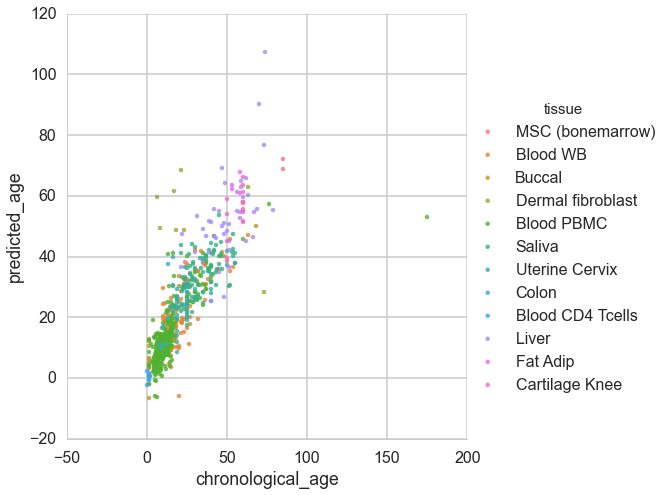

In [173]:
#plt.scatter(Yresp_test.values, test_predict)
#ax = plt.gca()
#x = np.linspace(*ax.get_xlim())
#plt.plot(x,x)
#plt.xlim(0,100)
#plt.ylim(-10,80)
plt.figure(figsize=(10, 10))
#plot the results by tissues
plotdf = pd.DataFrame({"chronological_age": Yresp_test.values, "predicted_age":test_predict , "tissue":preprocFull[~mask]["tissue_src"].values})
sns.lmplot("chronological_age", "predicted_age",fit_reg=False,scatter=True, size =7, data=plotdf,hue="tissue",legend="False", legend_out='False') 
#plt.legend(fontsize='8')

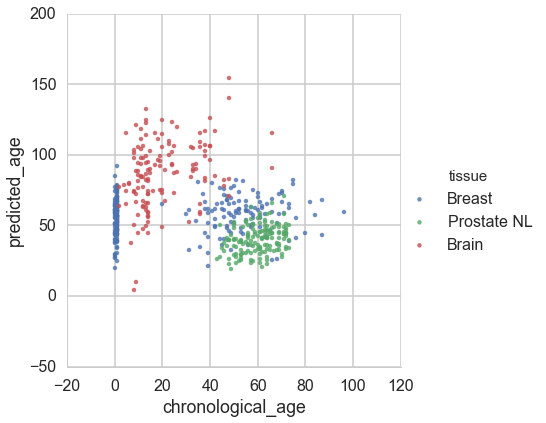

In [187]:
# Plot the results of predicting ages with cancer data
#plt.scatter(Yresp_cancer.values, cancer_predict)
#ax = plt.gca()
#plt.xlim(0,100)
#plt.ylim(-10,80)
plotdf = pd.DataFrame({"chronological_age": Yresp_cancer.values, "predicted_age":cancer_predict , "tissue":cancer['tissue_src'].values})
sns.lmplot("chronological_age", "predicted_age",size =6,fit_reg=False,scatter=True,data=plotdf,hue="tissue",legend=True) 
#x = np.linspace(*ax.get_xlim())
#plt.plot(x,x)


Most of the breast cancer tissues are off from 

In [117]:
wholemetDFx = preprocAll[metColumns]
wholemetDFy = pd.DataFrame(preprocAll['cancer'])
wholemetDFx = wholemetDFx.apply(replaceNan)
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(preprocAll.shape[0]), train_size=0.7)
mask_All=np.ones(preprocAll.shape[0], dtype='int')
mask_All[itrain]=1
mask_All[itest]=0
mask_All = (mask_All==1)
mask_All.shape, mask_All.sum()
XmatrixAll_train=wholemetDFx[mask_All]
XmatrixAll_test=wholemetDFx[~mask_All]
YrespAll_train=wholemetDFy[mask_All]['cancer']
YrespAll_test=wholemetDFy[~mask_All]['cancer']
print XmatrixAll_train.shape
print YrespAll_train.shape


(1931, 21368)
(1931,)


In [118]:
from sklearn.decomposition import PCA
pca = PCA()
X_All_reduced = pca.fit_transform(XmatrixAll_train)

In [119]:
sums = np.cumsum(pca.explained_variance_ratio_)*100
x = 0
k = 0
while (k<95):
    k = sums[x]
    x+=1
print "95% of variance explained in: ", x, " components"

95% of variance explained in:  246  components


In [120]:
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

n_All = len(X_All_reduced)
kf_All_5 = cross_validation.KFold(n_All, n_folds=5)
clfsvm=LinearSVC(loss="hinge")
ncomponents = [35, 70, 140, 280, 560, 1020, 2000]
mseScore_All = []

#Took out the scoring function - results in 70 components for linear SVM. We might want to do a GridSearch-type
#instead to 

for i in ncomponents:
    score = cross_validation.cross_val_score(clfsvm, X_All_reduced[:,:i], YrespAll_train, cv=kf_All_5).mean()
    mseScore_All.append(score)

print mseScore_All
#print "Highest score for:", ncomponents[mseScore_All.index(max(mseScore_All))-1], "components"

[0.91453588785797479, 0.92437509204589574, 0.91919240604624386, 0.92178977386833749, 0.92075216558889283, 0.91971723500823388, 0.92075350443828563]


In [121]:
pca = PCA(n_components=2000)
XtrainAll_new = pca.fit_transform(XmatrixAll_train)
XtestAll_new = pca.transform(XmatrixAll_test)

clfsvm.fit(XtrainAll_new, YrespAll_train)
testAll_predict = clfsvm.predict(XtestAll_new)

/Users/triptik/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


(0, 1)

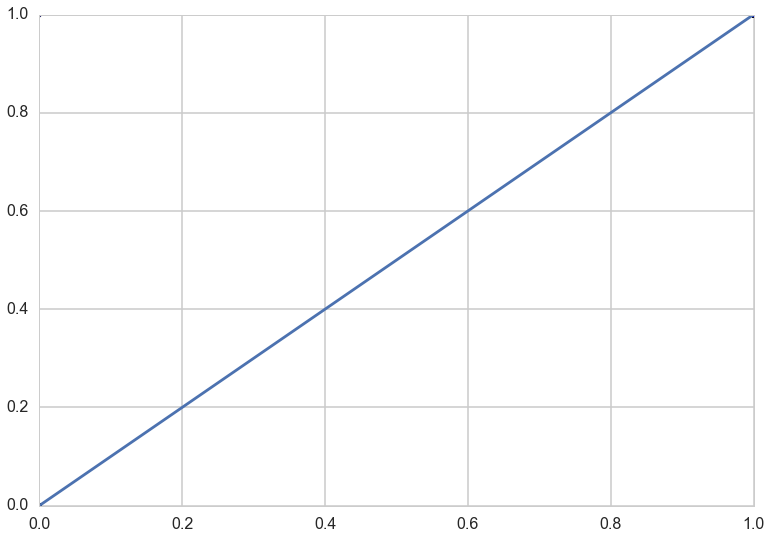

In [122]:
plt.scatter(YrespAll_test.values, testAll_predict)
ax = plt.gca()
x = np.linspace(*ax.get_xlim())
plt.plot(x,x)
plt.xlim(0,1)
plt.ylim(0,1)

In [123]:
from sklearn.metrics import confusion_matrix
confusion_matrix(YrespAll_test.values, testAll_predict)

array([[667,   1],
       [  0, 161]])

In [124]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, xtrain, ytrain,n_folds=5,score_func=None):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    fitmodel.fit(xtrain,ytrain)
    best=fitmodel.best_estimator_
    print best
    return best

In [125]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [126]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=(indf[featurenames]).apply(replaceNan)
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [127]:
#svm all features
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


In [128]:
%%time
clfsvm, Xtrain_new, ytrain_new, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C":Cs}, preprocAll, metColumns, 'cancer',1,mask=mask_All)


using mask
LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[668   0]
 [  2 159]]
########################################################
CPU times: user 4min 24s, sys: 27.5 s, total: 4min 51s
Wall time: 5min 20s


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [129]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0,fc=None):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.2 , fc=fc
    )
    
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right",fontsize=12)
    return ax

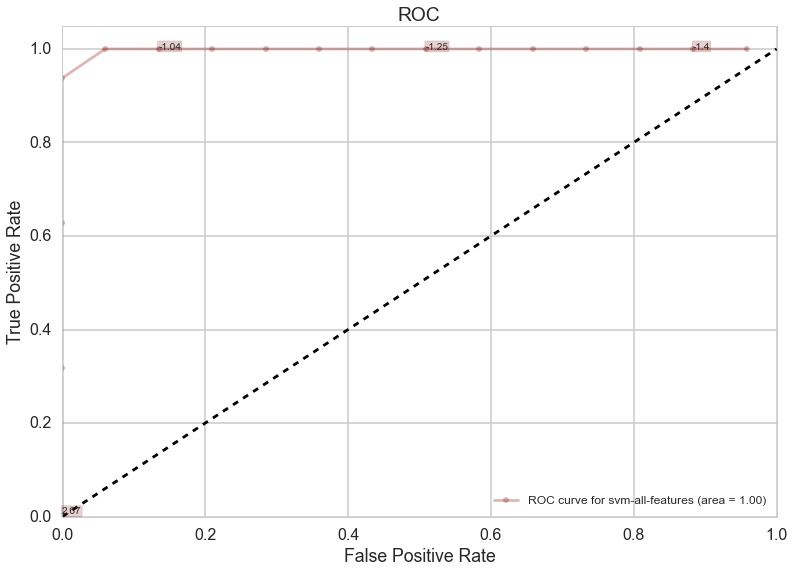

In [130]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=250, proba=False, skip=50);

In [131]:
opt_results = []
parameters = {"svm__C": Cs}
selectorlinearsvm = SelectKBest(k=40,score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [132]:
pipelinearsvm,Xtrain, ytrain, Xtest, ytest  = do_classify(pipelinearsvm, parameters, preprocAll, metColumns, 'cancer',1,mask=mask_All)

using mask
Pipeline(steps=[('select', SelectKBest(k=40, score_func=<function pearson_scorer at 0x19369b488>)), ('svm', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.97
[[648  20]
 [  9 152]]
########################################################


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [133]:
feature_selected_cols = np.array(metColumns)[pipelinearsvm.get_params()['select'].get_support()]
feature_selected_cols

array(['cg00221494', 'cg00332153', 'cg03473518', 'cg04289385',
       'cg04754011', 'cg07717632', 'cg09573795', 'cg09851465',
       'cg10660256', 'cg10934032', 'cg13282837', 'cg14417329',
       'cg14425294', 'cg15518950', 'cg15539420', 'cg15607672',
       'cg15824056', 'cg16463460', 'cg18345635', 'cg19096475',
       'cg19308222', 'cg19325985', 'cg19797376', 'cg19814116',
       'cg20073553', 'cg20588069', 'cg21233722', 'cg21296676',
       'cg21601405', 'cg21794225', 'cg21898046', 'cg21992250',
       'cg22377389', 'cg22609784', 'cg23282559', 'cg24840099',
       'cg25023994', 'cg26416466', 'cg26620356', 'cg27169020'], 
      dtype='|S10')

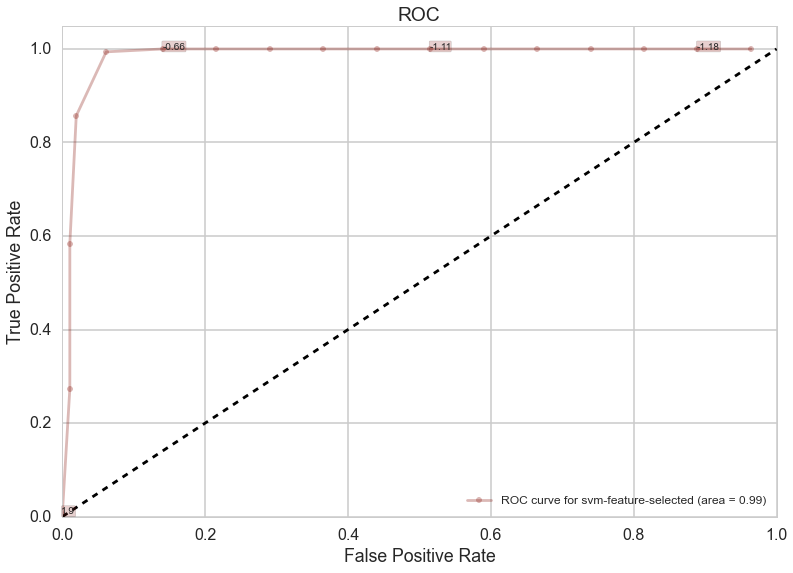

In [134]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, labe=250, proba=False, skip=50);

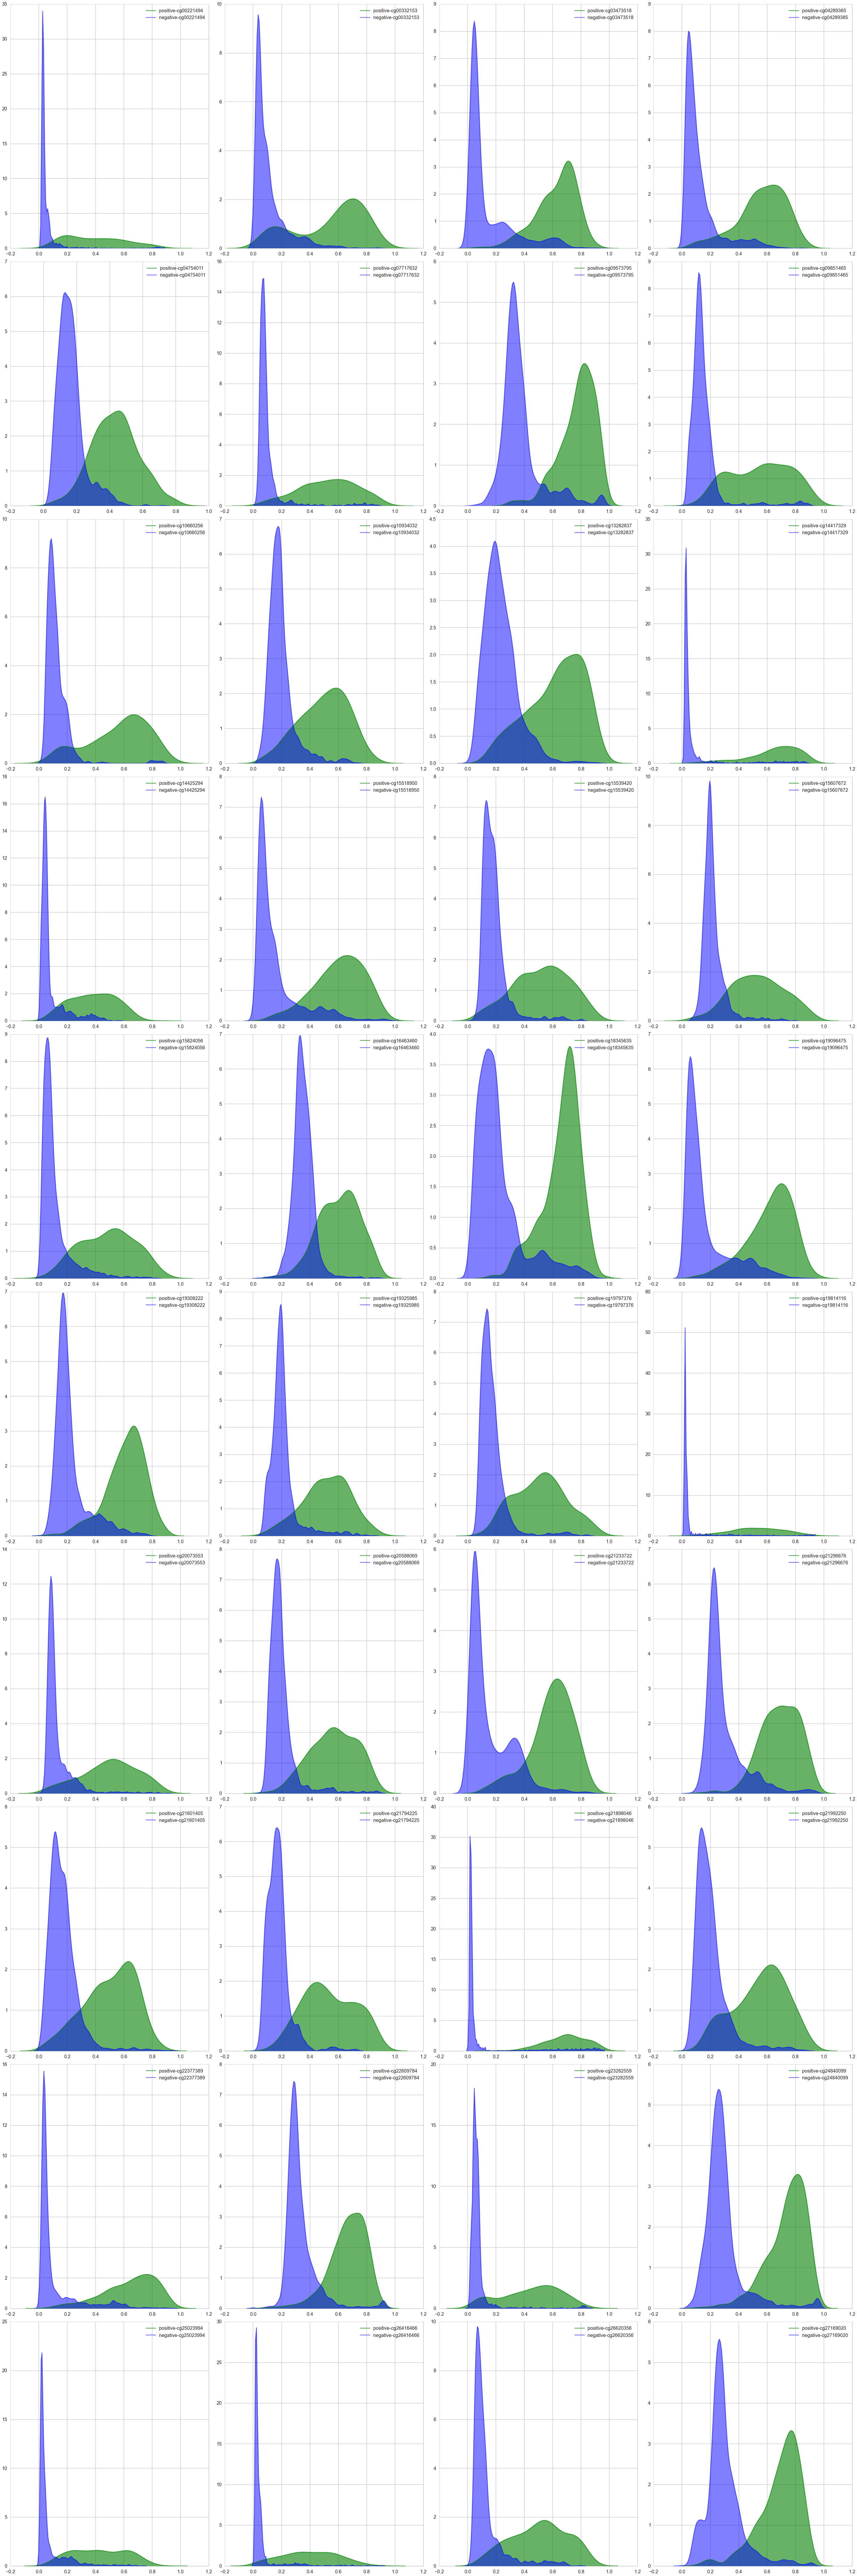

In [135]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(40, 120), 
                        tight_layout=True)
for ax1,colname in zip(axes.ravel(),feature_selected_cols):
    plot_kde(ax1,colname,preprocAll)

Plotted svm feature selected between cancer and non-cancer datasets again. We can notice most of them nice separation between the two classes.  Feature selection worked as expect. 

It will interesting to further study these biomarkers and the genes they are associated with.  It will be interesting in deducing if those genes are indeed implicated in aging process. 